### TODO:
* Check results of 10 epoch fox. How is the PSNR? Check PSNR in this file and in the testing file. Is there a difference in the reuslts?
    * The results were great! Excellent reconstruction quality in PSNR and in reconstruction.
* Check the 3D reconstruction. If all seems good, try again with torus.
    * Looked good. Tried again with torus.
* Check: is the testing function effecting the training function? compare results.
    * Yes! the testing function results are different. But **WHY**
* Try again with 1 epoch, lets see if tn tf changes things, being 0-10 instead of 8-14 for training

### NOTES:
* Last 1 epoch run: ~15 PSNR and good 3D reconstruction- once visualization code was removed.
* Do all work on the dev branch. The main branch is to keep everything preserved!
* Should start adding github issues
* Noticed sometimes the first result will just be poor. Not sure why this is.

In [1]:
import torch
import torch.nn as nn
import numpy as np

import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from dataset import get_rays
from model import Nerf
from ml_helpers import training

# Camera / Dataset

In [2]:
batch_size = 1024
height = 400
width = 400

o, d, target_px_values = get_rays('datasets/fox', mode='train')
dataloader = DataLoader(torch.cat((torch.from_numpy(o).reshape(-1, 3).type(torch.float),
                                   torch.from_numpy(d).reshape(-1, 3).type(torch.float),
                                   torch.from_numpy(target_px_values).reshape(-1, 3).type(torch.float)), dim=1),
                       batch_size=batch_size, shuffle=True)


dataloader_warmup = DataLoader(torch.cat((torch.from_numpy(o).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float),
                               torch.from_numpy(d).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float),
                               torch.from_numpy(target_px_values).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float)), dim=1),
                       batch_size=batch_size, shuffle=True)


test_o, test_d, test_target_px_values = get_rays('datasets/fox', mode='test')

# Training - Change model name

In [3]:
wpth_file = 'nerf_models/warmup.pth'
pth_file = 'nerf_models/fox7.pth'

100%|██████████| 3516/3516 [01:33<00:00, 37.77it/s]


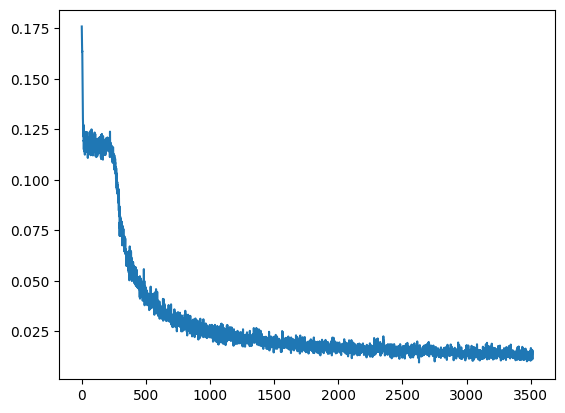

 29%|██▊       | 4017/14063 [01:46<04:25, 37.81it/s]

In [4]:
device = 'cuda'

tn = 0.
tf = 12.
nb_epochs = 1
lr = 1e-3
gamma = .5
nb_bins = 100

model = Nerf(hidden_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10], gamma=gamma)


training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, 1, dataloader_warmup, model_name=wpth_file, device=device)
plt.plot(training_loss)
plt.show()
training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, dataloader, model_name=pth_file, device=device)
plt.plot(training_loss)
plt.show()